In [1]:
# standard libraries
import importlib
from matplotlib import pyplot as plt
import numpy as np
from scipy.stats import norm
from scipy import linalg, stats, optimize
import time
import sys
sys.path.append('/Users/francescacrucinio/Documents/MD_LVM')

# modules from particles
import particles  # core module
from particles import smc_samplers as ssp
from particles import distributions as dists  # where probability distributions are defined
from particles import resampling as rs


import pgd
import md_lvm
import smc_mml
importlib.reload(pgd)
importlib.reload(md_lvm)
importlib.reload(smc_mml)

<module 'smc_mml' from '/Users/francescacrucinio/Documents/MD_LVM/smc_mml.py'>

## Data and marginal log-likelihood

In [2]:
y = np.array([-20, 1, 2, 3])
ndata = y.size

In [3]:
true_theta = 1.997

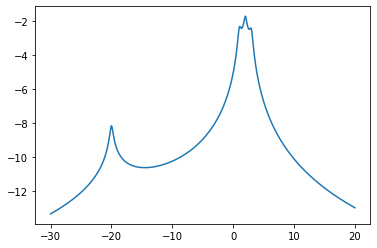

In [4]:
theta = np.linspace(-30, 20, num = 1000)
fun = 0
for i in range(4):
    fun = fun + np.log(0.05+(y[i]-theta)**2)
fun = -0.525*fun

plt.plot(theta, fun)

### MD vs PGD and IPLA

In [5]:
N = 1000
Niter = 2000
gamma = 0.001

th0 = np.array(0)  # Initial parameter guess.
X0 = np.random.gamma(size = (N, ndata), shape = 1)  # Initial particle cloud.

In [6]:
th_md, X_md, W_md = md_lvm.md_multimodal_fast(y, gamma, Niter, N, th0, X0)
th_pgd, X_pgd = pgd.pgd_multimodal(y, gamma, Niter, N, th0, X0)
th_ipla, X_ipla = pgd.ipla_multimodal(y, gamma, Niter, N, th0, X0)

/Users/francescacrucinio/Documents/MD_LVM/md_lvm.py:240: RuntimeWarning: invalid value encountered in log
  return -np.sum(0.475*np.log(x)+0.025*x+0.5*x*(y-theta)**2, axis = 1)
/Users/francescacrucinio/Documents/MD_LVM/md_lvm.py:240: RuntimeWarning: invalid value encountered in log
  return -np.sum(0.475*np.log(x)+0.025*x+0.5*x*(y-theta)**2, axis = 1)


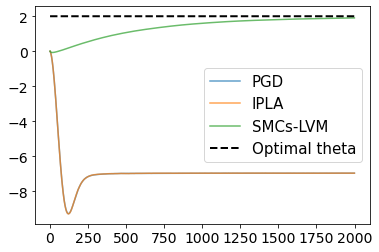

In [7]:
plt.plot(th_pgd, label='PGD', alpha = 0.7)
plt.plot(th_ipla, label='IPLA', alpha = 0.7)
plt.plot(th_md, label='SMCs-LVM', alpha = 0.7)
plt.plot(true_theta*np.ones(Niter), label='Optimal theta', c = 'black', linestyle = 'dashed', lw = 2)
plt.legend(loc='right', fontsize = 15)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
# plt.savefig('multimodal_unstable.pdf', bbox_inches="tight")

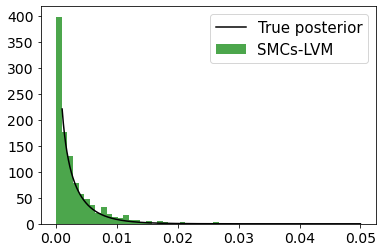

In [8]:
x = np.linspace(0.001, 0.05, num = 1000)
plt.hist(X_md[Niter-1, :, 0], density = True, bins = 30, weights = W_md, label='SMCs-LVM', alpha = 0.7, color = 'green');
# plt.hist(X_pgd[:, 0], density = True);
# plt.hist(X_ipla[:, 0], density = True);
plt.plot(x, stats.gamma.pdf(x, a = 0.525, scale = 1/(0.025+(y[0]-true_theta)**2/2)), label = 'True posterior',
        c = 'black')
plt.legend(fontsize = 15)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
# plt.savefig('multimodal_posterior_md.pdf', bbox_inches="tight")

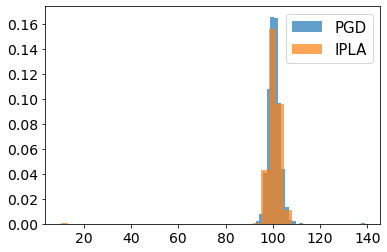

In [9]:
plt.hist(X_pgd[:, 3], density = True, bins = 30, label='PGD', alpha = 0.7);
plt.hist(X_ipla[:, 3], density = True, bins = 30, label='IPLA', alpha = 0.7);
plt.legend(fontsize = 15)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
# plt.savefig('multimodal_posterior_unstable.pdf', bbox_inches="tight")

## MD vs SMC of Johansen et al.

In [10]:
N = 50
Niter = 100
gamma = 0.01

th0 = np.array(0)  # Initial parameter guess.
X0 = np.random.gamma(size = (N, ndata), shape = 2)  # Initial particle cloud.

In [11]:
th_md, X_md, W_md = md_lvm.md_multimodal_fast(y, gamma, Niter, N, th0, X0)
th_smc, X_smc, W_smc = smc_mml.smc_mml_multimodal(N, Niter, y)

/Users/francescacrucinio/Documents/MD_LVM/md_lvm.py:240: RuntimeWarning: invalid value encountered in log
  return -np.sum(0.475*np.log(x)+0.025*x+0.5*x*(y-theta)**2, axis = 1)


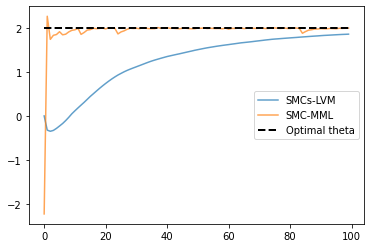

In [12]:
plt.plot(th_md, label='SMCs-LVM', alpha = 0.7)
plt.plot(th_smc, label='SMC-MML', alpha = 0.7)
plt.plot(true_theta*np.ones(Niter), label='Optimal theta', c = 'black', linestyle = 'dashed', lw = 2)
plt.legend(loc='right')
# plt.savefig('multimodal_stable.pdf', bbox_inches="tight")

(array([  0., 100., 200., 300., 400., 500., 600., 700.]),
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

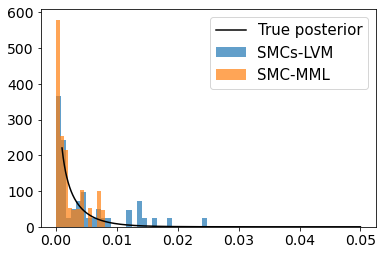

In [13]:
x = np.linspace(0.001, 0.05, num = 1000)
plt.hist(X_md[Niter-1, :, 0], density = True, weights = W_md, bins = 30, label='SMCs-LVM', alpha = 0.7);
plt.hist(X_smc[:, 0], density = True, weights = W_smc, bins = 30, label='SMC-MML', alpha = 0.7);
plt.plot(x, stats.gamma.pdf(x, a = 0.525, scale = 1/(0.025+(y[0]-true_theta)**2/2)), label = 'True posterior',
        c = 'black')
plt.legend(fontsize = 15)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
# plt.savefig('multimodal_posterior_md.pdf', bbox_inches="tight")

In [14]:
for i in range(4):
    true_sample = np.random.gamma(shape = 0.525, scale = 1/(0.025+(y[i]-true_theta)**2/2), size = N)
    w1_smc = stats.wasserstein_distance(X_smc[:, i], true_sample, W_smc)
    w1_md = stats.wasserstein_distance(X_md[Niter-1, :, i], true_sample, W_md)
    print(w1_smc, w1_md)

0.0009003104585797188 0.0020028126019727794
0.3159937086724434 0.34549601442220873
5.442405951649677 14.30024927175732
0.21455346166789854 0.3118309228619238


### Comparison same $N$

In [15]:
Nrep = 100
times = np.zeros((Nrep, 2))
estimates = np.zeros((Nrep, 2))

In [16]:
N = 100
Niter = 50
gamma = 0.05

In [17]:
for j in range(Nrep):
    th0 = np.array(0)  # Initial parameter guess.
    X0 = np.random.gamma(size = (N, ndata), shape = 2)  # Initial particle cloud.
    start = time.time()
    th_smc, X_smc, W_smc = smc_mml.smc_mml_multimodal(N, Niter, y)
    end = time.time()
    times[j, 0] = end-start
    estimates[j, 0] = th_smc[Niter-1]
    start = time.time()
    th_md, X_md, W_md = md_lvm.md_multimodal_fast(y, gamma, Niter, N, th0, X0)
    end = time.time()
    times[j, 1] = end-start
    estimates[j, 1] = th_md[Niter-1]

/Users/francescacrucinio/Documents/MD_LVM/md_lvm.py:240: RuntimeWarning: invalid value encountered in log
  return -np.sum(0.475*np.log(x)+0.025*x+0.5*x*(y-theta)**2, axis = 1)


In [18]:
np.mean(times, axis = 0)

array([0.29431653, 0.01857377])

In [19]:
np.mean(times, axis = 0)[0]/np.mean(times, axis = 0)[1]

15.845817218955169

In [20]:
np.mean((estimates - true_theta)**2, axis = 0)

array([0.00156347, 0.08522848])

In [21]:
np.mean((estimates - true_theta)**2, axis = 0)[1]/np.mean((estimates - true_theta)**2, axis = 0)[0]

54.51238372842497

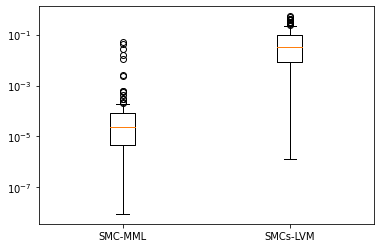

In [22]:
plt.boxplot((estimates - true_theta)**2, labels = ['SMC-MML', 'SMCs-LVM']);
plt.yscale('log')
# plt.savefig('multimodal_sameN.pdf', bbox_inches="tight")

In [23]:
np.var(estimates, axis = 0)

array([0.00153797, 0.0851914 ])

### Comparison same cost

In [24]:
Nrep = 100
times = np.zeros((Nrep, 2))
estimates = np.zeros((Nrep, 2))

In [25]:
N = 100
Niter = 50
gamma = 0.05

In [26]:
for j in range(Nrep):
    th0 = np.array(0)  # Initial parameter guess.
    X0 = np.random.gamma(size = (N, ndata), shape = 2)  # Initial particle cloud.
    start = time.time()
    th_smc, X_smc, W_smc = smc_mml.smc_mml_multimodal(N, Niter, y)
    end = time.time()
    times[j, 0] = end-start
    estimates[j, 0] = th_smc[Niter-1]
    X0 = np.random.gamma(size = (N, ndata), shape = 2)  # Initial particle cloud.
    start = time.time()
    th_md, X_md, W_md = md_lvm.md_multimodal_fast(y, gamma, Niter*15, N, th0, X0)
    end = time.time()
    times[j, 1] = end-start
    estimates[j, 1] = th_md[Niter-1]

/Users/francescacrucinio/Documents/MD_LVM/md_lvm.py:240: RuntimeWarning: invalid value encountered in log
  return -np.sum(0.475*np.log(x)+0.025*x+0.5*x*(y-theta)**2, axis = 1)


In [27]:
np.mean(times, axis = 0)

array([0.3005271 , 0.27977814])

In [28]:
np.mean(times, axis = 0)[0]/np.mean(times, axis = 0)[1]

1.0741621682664642

In [29]:
np.mean((estimates - true_theta)**2, axis = 0)

array([0.00055184, 0.08211751])

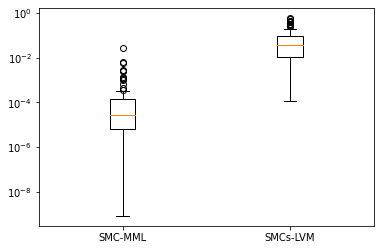

In [30]:
plt.boxplot((estimates - true_theta)**2, labels = ['SMC-MML', 'SMCs-LVM']);
plt.yscale('log')
# plt.savefig('multimodal_samecost.pdf', bbox_inches="tight")

In [31]:
np.var(estimates, axis = 0)

array([0.00052398, 0.07720863])